LOAD DATASET

In [1]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt

df = pd.read_csv("./dataset.csv", sep=";")
df = df.drop_duplicates()

CLEAN SERVICES


In [2]:
df["Is_Service_National"] = df["Service"] == "National"
df["Is_Service_International"] = df["Service"] == "International"

df = df.drop(columns="Service")

CLEAN GARE NAME


In [3]:
cols_gare = ["Gare d'arrivée", "Gare de départ"]
df = df.dropna(subset=cols_gare)
df[cols_gare] = df[cols_gare].astype(str).apply(lambda x: x.str.strip().str.upper())
df = df[(df["Gare d'arrivée"] != "0") &(df["Gare de départ"] != "0")]
df = df[df["Gare d'arrivée"] != df["Gare de départ"]]
df = df.drop_duplicates(
    subset=["Gare de départ", "Gare d'arrivée", "Date"],
    keep="first"
)

CLEAN DATES


In [4]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", format="%Y-%m")
df["Date"] = df["Date"].dt.to_period("M")

df = df.dropna(subset=["Date"])

df["Year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month

CLEAN NUMERIC COLOMN


In [5]:
cols_num = [
    "Retard moyen trains en retard > 15 (si liaison concurrencée par vol)",
    "Retard moyen de tous les trains au départ",
    "Retard moyen des trains en retard à l'arrivée",
    "Retard moyen de tous les trains à l'arrivée",
    "Durée moyenne du trajet",
    "Retard moyen des trains en retard au départ",
    "Nombre de circulations prévues",
    "Nombre de trains annulés",
    "Nombre de trains en retard au départ",
    "Nombre de trains en retard à l'arrivée",
    "Nombre trains en retard > 30min",
    "Nombre trains en retard > 15min",
    "Nombre trains en retard > 60min",
]

df[cols_num] = (
    df[cols_num]
    .astype(str)
    .apply(lambda x: x.str.replace("min", "").str.replace(",", ".").str.strip())
)
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors="coerce")
df = df[(df[cols_num] >= 0).all(axis=1)]


DROP STRING COLOMN


In [6]:
cols_string = [
    "Commentaire retards au départ",
    "Commentaire annulations",
    "Commentaire retards à l'arrivée",
]

df = df.drop(columns=cols_string)


CLEAN POURCENTAGE COLOMN


In [7]:
cols_pourcentage = [
    "Prct retard pour causes externes",
    "Prct retard pour cause infrastructure",
    "Prct retard pour cause gestion trafic",
    "Prct retard pour cause matériel roulant",
    "Prct retard pour cause gestion en gare et réutilisation de matériel",
    "Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)",
]

df[cols_pourcentage] = (
    df[cols_pourcentage]
    .astype(str)
    .apply(lambda x: x.str.replace("%", "").str.replace(",", ".").str.strip())
)
df[cols_pourcentage] = df[cols_pourcentage].apply(pd.to_numeric, errors="coerce")
df = df[(df[cols_pourcentage] >= 0).all(axis=1)]

LAST CLEAN


In [8]:
df = df[df["Durée moyenne du trajet"].astype(int) > 0]
df = df[df["Nombre de circulations prévues"].astype(int) > 0]

cols_to_int = [
    "Nombre de trains annulés",
    "Nombre de circulations prévues",
    "Nombre de trains en retard au départ",
    "Nombre de trains en retard à l'arrivée",
    "Nombre trains en retard > 15min",
    "Nombre trains en retard > 30min",
    "Nombre trains en retard > 60min",
]
df[cols_to_int] = df[cols_to_int].astype("int")

df = df.dropna()
df.to_csv("cleaned_dataset.csv", index=False)


In [9]:
df.groupby(["Gare de départ"]).size().agg(["mean", "max", "min", "median", "sum"])


mean       118.0
max       1503.0
min          1.0
median      63.0
sum       7434.0
dtype: float64

In [10]:
stats_arrivées = (
    df.groupby("Gare de départ").size().agg(["mean", "max", "min", "median", "sum"])
)
stats_de_départ = (
    df.groupby("Gare de départ").size().agg(["mean", "max", "min", "median", "sum"])
)
print("Statistiques de stats_arrivées :\n", stats_arrivées)
print("Statistiques de stats_de_départ :\n", stats_de_départ)

Statistiques de stats_arrivées :
 mean       118.0
max       1503.0
min          1.0
median      63.0
sum       7434.0
dtype: float64
Statistiques de stats_de_départ :
 mean       118.0
max       1503.0
min          1.0
median      63.0
sum       7434.0
dtype: float64


Text(0.5, 1.0, 'Retard moyen pour gares par rapport au temps moyen de trajet')

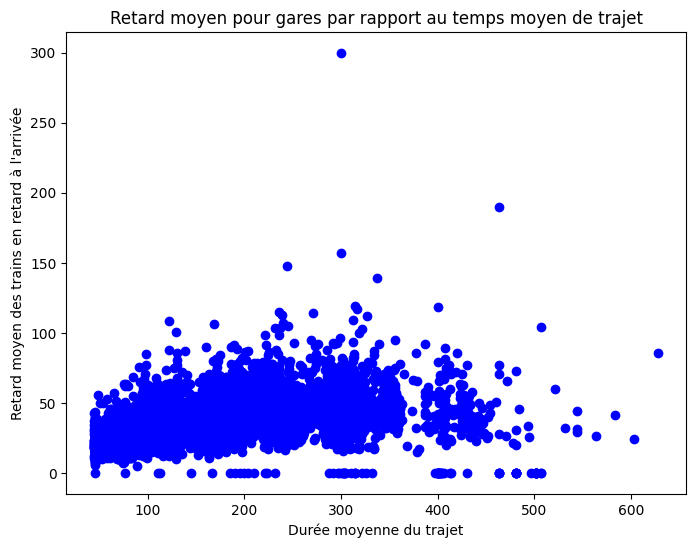

In [11]:
fig_scatter = plt.figure(figsize=(8, 6))
ax_scatter = plt.gca()

X_array = df["Durée moyenne du trajet"]
Y_array = df["Retard moyen des trains en retard à l'arrivée"]


ax_scatter.scatter(X_array, Y_array, c="blue")
ax_scatter.set_xlabel("Durée moyenne du trajet")
ax_scatter.set_ylabel("Retard moyen des trains en retard à l'arrivée")
ax_scatter.set_title("Retard moyen pour gares par rapport au temps moyen de trajet")


(20, 6)


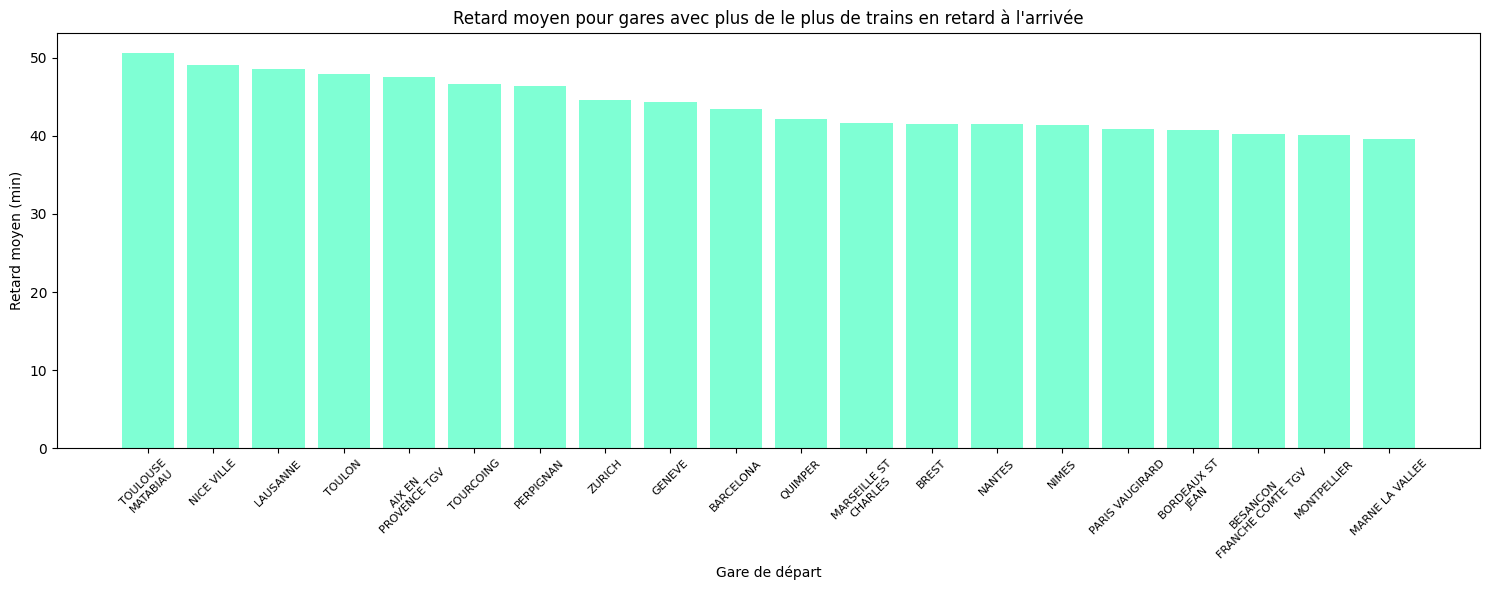

In [12]:
df_filtered = df

df_filtre = (
    df_filtered.groupby("Gare de départ")[
        "Retard moyen des trains en retard à l'arrivée"
    ]
    .agg(["mean", "max", "min", "median", "sum"])
    .reset_index()
)

df_filtre = df_filtre.sort_values(by="mean", ascending=False)

df_filtre = df_filtre.head(20)

print(df_filtre.shape)

X_array = df_filtre["Gare de départ"]
Y_array = df_filtre["mean"]

fig2, ax2 = plt.subplots(figsize=(15, 6))
ax2.bar(X_array, Y_array, color="aquamarine")
ax2.set_xlabel("Gare de départ")
ax2.set_ylabel("Retard moyen (min)")
ax2.set_title(
    "Retard moyen pour gares avec plus de le plus de trains en retard à l'arrivée"
)
ax2.set_xticks(range(len(X_array)))
wrapped_labels = [
    (
        label[:bp] + "\n" + label[bp + 1 :]
        if (bp := label.rfind(" ", 0, 15)) != -1
        else label[:15] + "\n" + label[15:]
    )
    if len(label) > 15
    else label
    for label in X_array
]
ax2.set_xticklabels(wrapped_labels, fontsize=8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

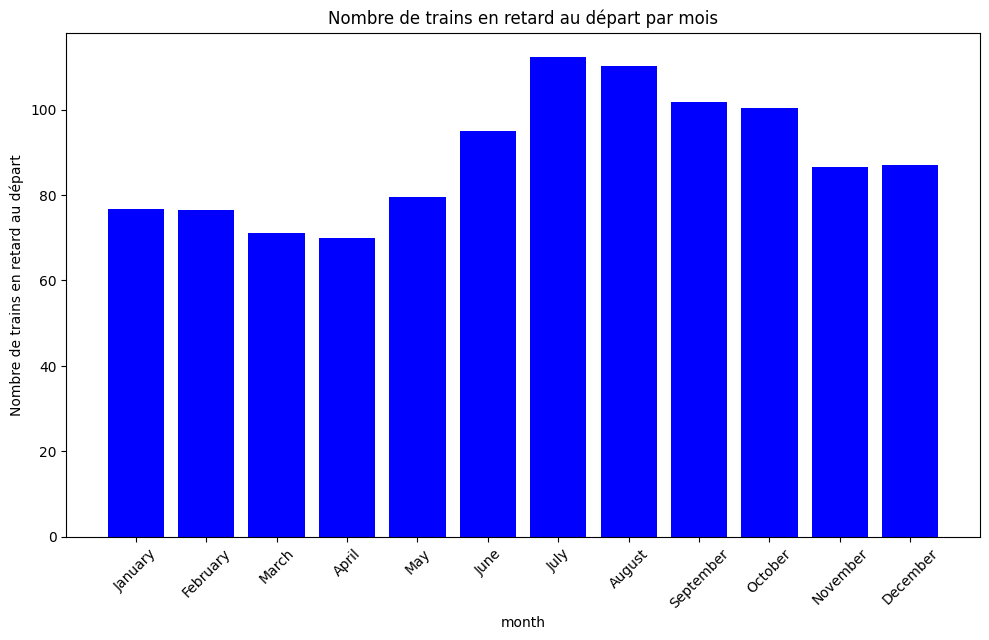

In [13]:
df_filtered = df

df_filtre = (
    df_filtered.groupby("month")["Nombre de trains en retard au départ"]
    .agg(["mean", "max", "min", "median", "sum"])
    .reset_index()
)

df_filtre = df_filtre.sort_values(by="month")

X_array = [calendar.month_name[month_number] for month_number in df_filtre["month"]]
Y_array = df_filtre["mean"]

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(X_array, Y_array, color="blue")
ax2.set_xlabel("month")
ax2.set_ylabel("Nombre de trains en retard au départ")
ax2.set_title("Nombre de trains en retard au départ par mois")
ax2.set_xticks(range(len(X_array)))
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

GENERATE DIAGRAMME

(20, 6)


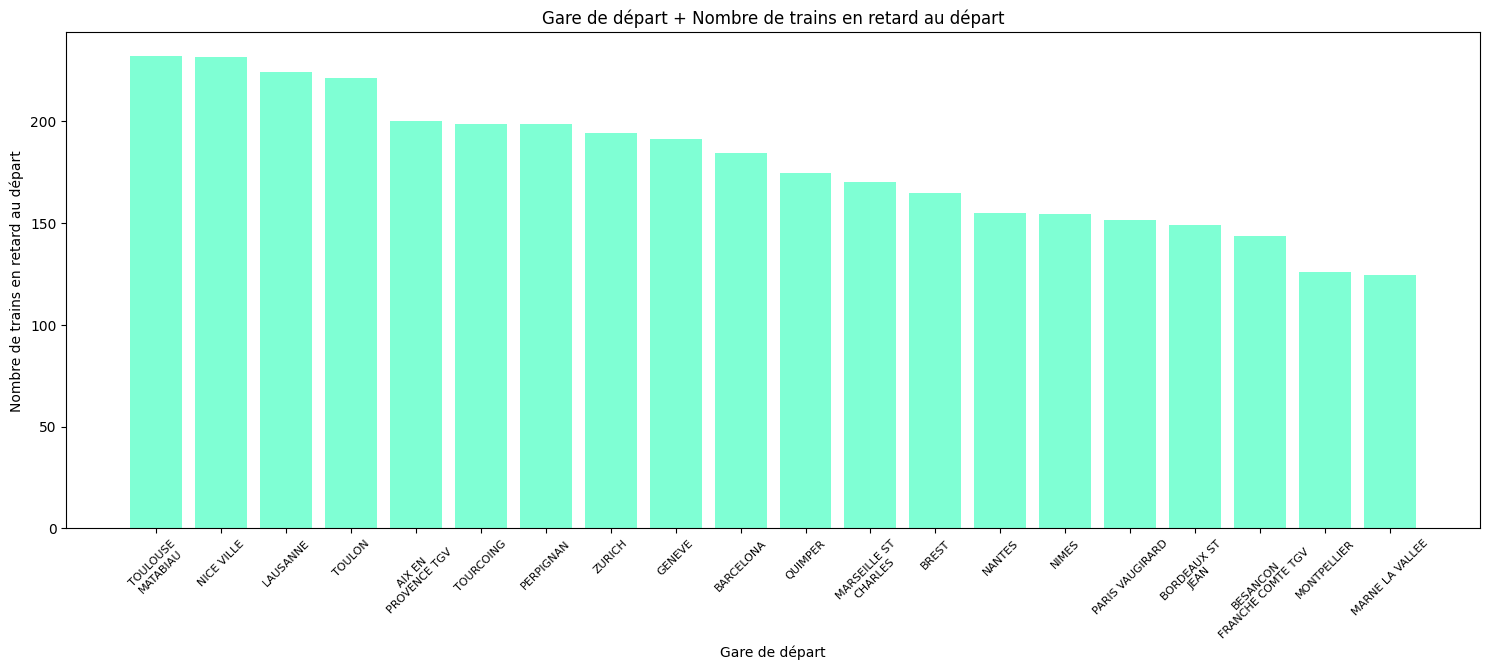

In [14]:
def diagramme_gen(X: str, Y: str,*, number: int | None = None):
    if not isinstance(X, str) or not isinstance(Y, str):
        return "argument must be string"
    if number is not None and not isinstance(number, int):
        return "number must be int" 
    if X not in cols_gare :
        return "not in gare"
    if Y not in cols_num :
        return "not in value"

    df_filtered = df

    df_filtre = (df_filtered.groupby(X)[Y].agg(["mean", "max", "min", "median", "sum"]).reset_index())

    df_filtre = df_filtre.sort_values(by="mean", ascending=False)

    df_filtre = df_filtre.head(20)

    print(df_filtre.shape)

    X_array = df_filtre[X]
    Y_array = df_filtre["mean"]

    fig3, ax3 = plt.subplots(figsize=(15, 6))
    ax3.bar(X_array, Y_array, color="aquamarine")
    ax3.set_xlabel(f"{X}")
    ax3.set_ylabel(f"{Y}")
    ax3.set_title(f"{X} + {Y}")
    ax3.set_xticks(range(len(X_array)))
    ax3.set_xticklabels(wrapped_labels, fontsize=8)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
    
diagramme_gen("Gare de départ","Nombre de trains en retard au départ")